In [7]:
# Install instructions for replicating the environment for GPAW

# 1. Python headers: To ensure compatibility with the Python version in use, install the Python development headers.
#    On Ubuntu/Debian: `sudo apt-get install python3-dev` or the appropriate package for your Python version.

# 2. LibXC: GPAW requires the LibXC library for exchange-correlation functional computations.
#    Install it via: `sudo apt-get install libxc-dev`

# 3. BLAS/LAPACK: These libraries are essential for numerical linear algebra operations required by GPAW.
#    On Ubuntu/Debian: `sudo apt-get install libblas-dev liblapack-dev`

# 4. GPAW Installation: Once dependencies are in place, install GPAW using pip:
#    `pip install gpaw`

# Make sure that all these dependencies are installed to successfully compile and use GPAW in your projects.

In [22]:
%pip install --upgrade pip
%pip install ase gpaw matplotlib nibabel numpy pandas vtk contourpy
%pip install --upgrade scipy
%pip install rdkit nibabel matplotlib tqdm
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
import sys
import time
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import read, write
from gpaw import GPAW, PW, Mixer, Davidson
import nibabel as nib
from ase.visualize import view
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem
from ase import Atoms
import subprocess
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
from skimage.feature import peak_local_max

In [37]:
# Directory Paths
SDF_DIR = 'data/sdf'
CIF_DIR = 'data/cif'
NII_DIR = 'data/nii'
TXT_FILES = 'data/txt'  # Folder for text files (GPAW calculation logs)
DENSITY_FILES = 'data/density'  # Folder for density .cube files

# Ensure output directories exist
os.makedirs(NII_DIR, exist_ok=True)
os.makedirs(CIF_DIR, exist_ok=True)
os.makedirs(TXT_FILES, exist_ok=True)
os.makedirs(DENSITY_FILES, exist_ok=True)


In [38]:
# # $ gpaw test
# # ...
# # Could not find any atomic PAW-data or pseudopotentials!

# # You need to set the GPAW_SETUP_PATH environment variable to point to
# # the directories where PAW dataset and basis files are stored.  See
# # https://wiki.fysik.dtu.dk/gpaw/install.html#install-paw-datasets
# # for details.

# on getting this type of error, you can run following commands to fix it:
# $ gpaw install-data --register ~/PAWDATA
# $ export GPAW_SETUP_PATH=~/PAWDATA
# $ source ~/.bashrc

# then restart the kernel (if using ipynb) and run the code again

# Refer to this: https://jensj.gitlab.io/gpaw-2021-talk/slides/slide-09.html

In [39]:
def sdf_to_cif(sdf_filepath):
    mol = read(sdf_filepath)
    mol.center(vacuum=2.5)
    filename = sdf_filepath.split('/')[-1].split('.')[0]
    cif_filepath = os.path.join(CIF_DIR, filename + '.cif')
    write(cif_filepath, mol)
    return mol  # Step 1: Read molecular data from .sdf file

def sdf_to_cif_via_rdkit(sdf, cif_out, vacuum=2.5):
    # load (skipping any bad records)
    suppl = Chem.SDMolSupplier(sdf, removeHs=False, sanitize=False, strictParsing=False)
    mol = next((m for m in suppl if m is not None), None)
    if mol is None:
        print(f"Failed to parse {sdf} in RDKit")
        return None

    # sanitize & embed if needed
    try:
        Chem.SanitizeMol(mol)
    except:
        pass
    if mol.GetNumConformers() == 0:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()
    coords = conf.GetPositions()
    syms   = [atom.GetSymbol() for atom in mol.GetAtoms()]

    ase_mol = Atoms(symbols=syms, positions=coords)
    ase_mol.center(vacuum=vacuum)
    write(cif_out, ase_mol)
    return ase_mol

molecules = []
mol_filenames = []
for filename in os.listdir(SDF_DIR):
    if filename.endswith(".sdf"):
        file_path = os.path.join(SDF_DIR, filename)
        mol_filenames.append(filename[:-4])  # Store filename (without extension) for saving later
        mol = sdf_to_cif_via_rdkit(file_path, os.path.join(CIF_DIR, filename[:-4] + '.cif'))
        molecules.append(mol)

Processing h2o...


/tmp/ipykernel_5473/2629833025.py:21: FutureWarning: Please use atoms.calc = calc
  molecule.set_calculator(calc)


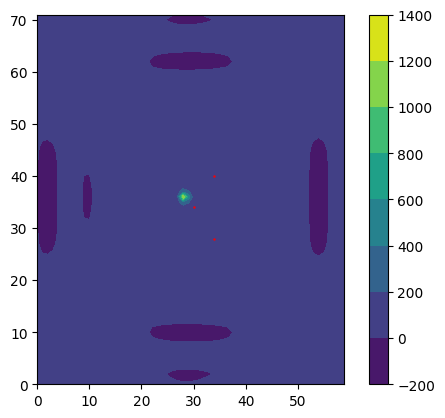

Sum of processed image for h2o: -5.421010862427522e-17
Processing D-Fructose...


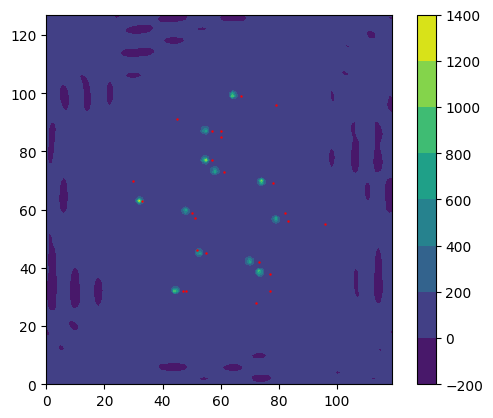

Sum of processed image for D-Fructose: 9.459148958904096e-15
Processing d-fructose...


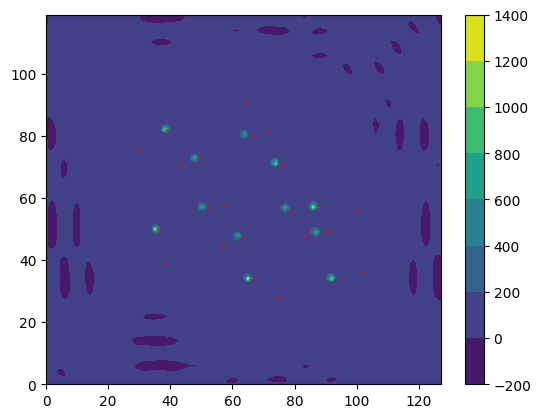

Sum of processed image for d-fructose: -5.878611941852185e-15
Processing hf...


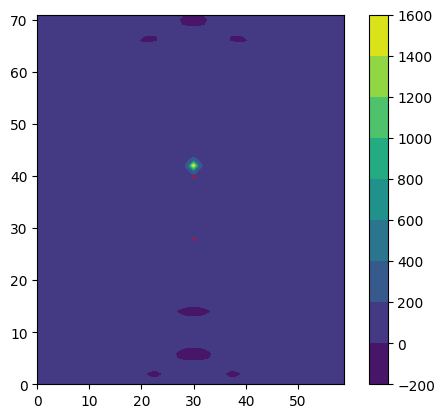

Sum of processed image for hf: -3.4474918579607827e-16
Processing times (seconds): [0.5222347499999955, 195.694998033, 207.76158970400002, 0.5720206240000607]
Calculated energies (eV): {'h2o': np.float64(52.96521936714853), 'D-Fructose': np.float64(131.42682935367253), 'd-fructose': np.float64(132.0088064796753), 'hf': np.float64(64.74410312348715)}


In [40]:
cutoffs = [150]  # Example list of cutoff values
times = []
energies = {}  # To store the calculated energies per molecule
calcs = []
densities = []  # To store the calculated densities

for j, molecule in enumerate(molecules):
    print(f"Processing {mol_filenames[j]}...")
    
    # Loop through the cutoff values (for each molecule; you can choose one or loop over all)
    # Here, we use the last cutoff in the list (or you can adjust as needed)
    for cutoff in cutoffs:
        start_time = time.process_time()

        # GPAW calculator setup
        calc = GPAW(xc='LDA',               # Exchange-correlation functional
                    kpts=(1, 1, 1),           # k-points for sampling
                    mode=PW(cutoff),          # Plane wave mode with cutoff energy
                    txt=os.path.join(TXT_FILES, mol_filenames[j] + '.txt')
                   )
        molecule.set_calculator(calc)
        
        # Calculate potential energy
        energy = molecule.get_potential_energy()
        energies[mol_filenames[j]] = energy
        times.append(time.process_time() - start_time)
        
        # Calculate electron density
        density = calc.get_all_electron_density(gridrefinement=4)
        densities.append(density)
        
        # Save the density as a .cube file
        density_file = os.path.join(DENSITY_FILES, mol_filenames[j] + '.cube')
        write(density_file, molecule, data=density)
        
        # ---------------- Change Start: Processing the .cube file similar to the provided code ----------------
        # Open the newly written cube file and skip header lines
        with open(density_file, 'r') as f:
            for _ in range(6):  # Skip the first 6 header lines
                f.readline()
            
            # Read the rest of the file to extract data rows with exactly 5 numbers
            data = np.zeros((0, 5))
            go = True
            while go:
                s = f.readline()
                sNump = np.fromstring(s, sep=' ')
                if sNump.shape[0] == 5:
                    data = np.concatenate((data, [sNump]))
                else:
                    go = False

        # Process extracted data to obtain coordinate positions (likely corresponding to nuclei)
        max_coords = data[:, 2:]  # CHANGE: Extract columns 3-5 from data array
        max_coords[:, 1] *= 6.45  # CHANGE: Scale second coordinate by 6.45
        max_coords[:, 0] *= 6.05  # CHANGE: Scale first coordinate by 6.05
        max_coords[:, 2] = density.shape[2] / 2  # CHANGE: Set the third coordinate to half the density's z-dimension
        max_coords = np.int64(max_coords)
        
        # Project density along the z-axis to obtain a 2D map for visualization (optional)
        nred = np.sum(density, axis=2)
        plt.contourf(nred)
        plt.colorbar()
        ax = plt.gca()
        fig = plt.gcf()
        # Overlay the positions (swapping x and y for plotting consistency)
        plt.scatter(max_coords[:, 1], max_coords[:, 0], c='r', marker='o', s=(72./fig.dpi)**2)
        ax.set_aspect(1)
        plt.show()
        
        # Prepare density for image processing: remove negatives
        density2 = np.copy(density)
        density2[density2 < 0] = 0
        
        # Sum the density at each nuclear position
        nbAtom = max_coords.shape[0]  # CHANGE: Number of atoms/points detected from cube data
        s_total = 0
        for i in range(nbAtom):
            s_total += density2[tuple(max_coords[i, :])]
        
        # Compute a scaled image from density data
        image = -density2 / ((np.sum(density2) - s_total) / nbAtom)
        
        # Mark the nuclear positions in the image (set to 1)
        for i in range(nbAtom):
            image[tuple(max_coords[i, :])] = 1  # CHANGE: Override nucleus position value with 1
        print(f"Sum of processed image for {mol_filenames[j]}:", np.sum(image))
        # ---------------- Change End --------------------------------------------

        # Convert the (processed) density to .nii format.
        # CHANGE: You can choose to save the original density or the processed "image".
        # Here, we choose to save the original density as in the provided snippet.
        nii_file = os.path.join(NII_DIR, mol_filenames[j] + '.nii')
        nifti_img = nib.Nifti1Image(density, affine=None)
        nib.save(nifti_img, nii_file)
        # If you'd rather save the processed image, use:
        # nifti_img = nib.Nifti1Image(image, affine=None)
        # nib.save(nifti_img, nii_file)

# After processing all molecules, output timing and energy information
print("Processing times (seconds):", times)
print("Calculated energies (eV):", energies)


/tmp/ipykernel_5473/3257993124.py:14: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  sNump = np.fromstring(s, sep=' ')


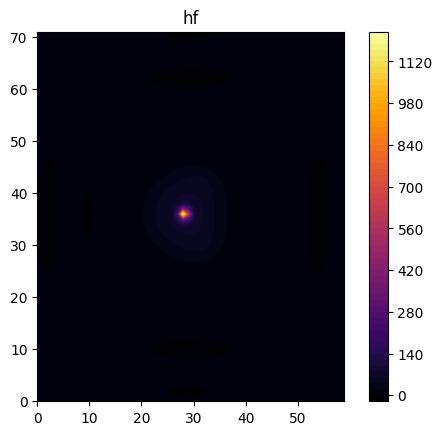

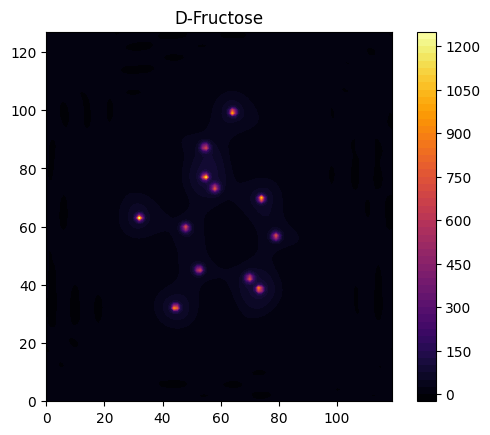

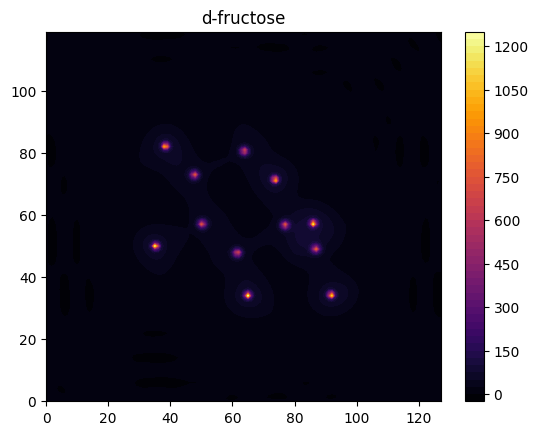

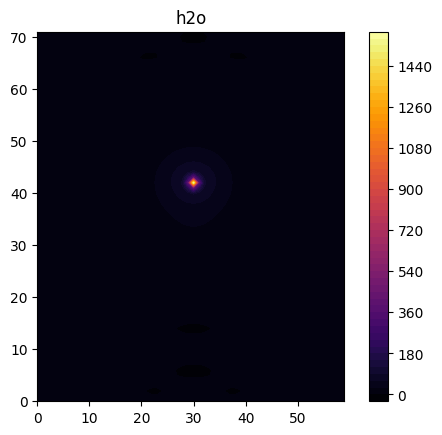

In [41]:
DENSITY_FILES = "data/density"  # update this to your actual directory

data_list = []
molecule_names = []

# Loop over files and load data; also store the filename (or molecule name)
for filename in os.listdir(DENSITY_FILES):
    pFile = os.path.join(DENSITY_FILES, filename)
    with open(pFile, 'r') as file:
        data = np.zeros((0, 5))
        go = True
        while go:
            s = file.readline()
            sNump = np.fromstring(s, sep=' ')
            if sNump.shape[0] == 5:
                data = np.concatenate((data, [sNump]))
            else:
                go = False
    data_list.append(data)
    molecule_names.append(filename.split('.')[0])  # store the filename (or use another label if desired)

# Assuming that 'densities' is defined somewhere and is in one-to-one correspondence with data_list.
# Loop through data_list (and molecule_names) to process each density and atom information
for i in range(len(data_list)):
    # Process atom positions from your data - you might need to adjust depending on your data structure.
    # Here, max is assumed to contain the atom positions in columns 2 onward.
    max_data = data_list[i][:, 2:]
    # Scale factors for more prominent atom positions and larger spread
    max_data[:, 1] *= 8.0  # Increased scaling factor for X
    max_data[:, 0] *= 7.5  # Increased scaling factor for Y
    
    # Setting the third coordinate, assuming densities[i] is 3D and you want to center the atoms.
    # Adjust this if densities is defined differently.
    max_data[:, 2] = densities[i].shape[2] / 2  
    max_data = np.int64(max_data)

    # Sum over the third axis to create a 2D grid, this gives your density contour plot
    nred = np.sum(densities[i], axis=2)

    # (Optional) sort densities if needed
    sortedDensity = np.argsort(densities[i].flatten())

    # Create a contour plot with more levels for finer distinction
    plt.contourf(nred, levels=60, cmap='inferno')
    plt.colorbar()

    ax = plt.gca()
    fig = plt.gcf()

    # Scatter plot for atoms (using the scaled positions)
    atom_size = (72. / fig.dpi)**2 * 2  # Increase marker size by a factor of 2
    plt.scatter(max_data[:, 1], max_data[:, 0], c='r', marker='o', s=atom_size)
    
    # Add the molecule name as a label/title on the plot
    plt.title(molecule_names[i])
    
    # Optionally, you can also annotate individual atom positions:
    # for j, (x, y, z) in enumerate(max_data):
    #     plt.text(x, y, str(j), color='w', fontsize=8)
    
    # Set the aspect ratio to keep the plot proportional
    ax.set_aspect(1)
    
    # Display the plot
    plt.show()


In [42]:
# # Loop through all the NII files
# for filename in os.listdir(NII_DIR):
#     if filename.endswith(".nii"):
#         nii_filepath = os.path.join(NII_DIR, filename)
#         nii_data = nib.load(nii_filepath).get_fdata()
        
#         # Get the number of slices along the z-axis (assuming it's the third axis)
#         num_slices = nii_data.shape[2]
        
#         # Set the maximum number of slices per row (5 to 7 slices)
#         slices_per_row = 7  # Maximum slices per row
#         rows = (num_slices // slices_per_row) + (num_slices % slices_per_row > 0)  # Calculate the number of rows

#         # Create a figure with subplots
#         fig, axes = plt.subplots(rows, slices_per_row, figsize=(20, 4 * rows))  # Adjust the figsize as needed
        
#         # Flatten axes array if it's multi-dimensional
#         axes = axes.flatten()

#         # Loop through each slice and plot it
#         for slice_index in range(num_slices):
#             ax = axes[slice_index]
#             ax.imshow(nii_data[:, :, slice_index], cmap='jet')  # Display the slice
            
#             # Format the title with the slice index and its x, y, z positions
#             z_index = slice_index  # The slice index along the z-axis
#             x_index = nii_data.shape[0] // 2  # Example: middle of the x-axis
#             y_index = nii_data.shape[1] // 2  # Example: middle of the y-axis
#             ax.set_title(f"Slice {z_index} [{x_index}:{y_index}:{z_index}]")  # Title with slice index and coordinates
            
#             ax.axis('off')  # Hide the axes

#         # Hide any unused subplots (if num_slices is less than the total subplot grid)
#         for i in range(num_slices, len(axes)):
#             axes[i].axis('off')

#         # Adjust layout to avoid overlapping titles and axes
#         plt.tight_layout()
#         plt.show()


In [43]:
def process_single_file(file_name, input_data, output_keypoint_images):
    """
    Processes a single .nii file by constructing the command and running it.
    """
    input_file_path = os.path.join(input_data, file_name)
    output_file_name = file_name.replace('.nii', '.key')
    output_file_path = os.path.join(output_keypoint_images, output_file_name)
    command = ['./../featExtract.ubu', input_file_path, output_file_path]
    
    try:
        result = subprocess.run(command, check=True, capture_output=True, text=True)
        print(f"Successfully processed {file_name}")
    except subprocess.CalledProcessError as e:
        print(f"Error processing {file_name}: {e.stderr}")

def process_nii_files(input_data, output_keypoint_images):
    """
    Processes all .nii files in the input folder in parallel and generates corresponding .key files in the output folder.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_keypoint_images):
        os.makedirs(output_keypoint_images)
    
    # Get the list of all .img files in the input folder
    img_files = [file for file in os.listdir(input_data) if file.endswith('.nii')]
    
    # Use a ProcessPoolExecutor to process files in parallel
    with ProcessPoolExecutor() as executor:
        # Submit all files for processing
        futures = {
            executor.submit(process_single_file, file_name, input_data, output_keypoint_images): file_name
            for file_name in img_files
        }
        # Use tqdm to display progress as futures complete
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files", unit="file"):
            try:
                future.result()  # Raises exception if one occurred in process_single_file
            except Exception as e:
                print(f"Error occurred: {e}")

# Example usage:
input_data = "data/nii"
output_keypoint_images = "data/key_website_pre-compiled/"  # Change if you want to save in a different folder
process_nii_files(input_data, output_keypoint_images)

Processing files:   0%|          | 0/7 [00:00<?, ?file/s]

Successfully processed h2o.nii


Processing files:  14%|█▍        | 1/7 [00:00<00:01,  3.40file/s]

Successfully processed hf.nii
Successfully processed D-Fructose.nii


Processing files:  43%|████▎     | 3/7 [00:01<00:02,  1.61file/s]

Successfully processed d-fructose.nii
Successfully processed AQ7000_222_O_B.nii


Processing files:  71%|███████▏  | 5/7 [00:06<00:02,  1.44s/file]

Successfully processed AQ7000_222_SI_B.nii
Successfully processed AQ7000_222_SI_2B.nii


Processing files: 100%|██████████| 7/7 [00:06<00:00,  1.10file/s]


In [44]:
import key2vtk

key2vtk.main(
    # base_path="~/Desktop/Experiments/molecules/data",
    # key_subdir="key_website_pre-compiled",
    # vtk_subdir="vtk_website_pre-compiled"
)

2025-10-17 15:42:54,330 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/Crystals/data/key_website_pre-compiled/D-Fructose.key:              X           Y          Z     Scale       o11       o12       o13  \
0    49.343227  102.918930  17.153448  3.893006 -0.198427 -0.234647 -0.951613   
1    49.343227  102.918930  17.153448  3.893006 -0.196844 -0.588492  0.784175   
2    49.343227  102.918930  17.153448  3.893006 -0.196844 -0.588492  0.784175   
3    49.343227  102.918930  17.153448  3.893006 -0.196844 -0.588492  0.784175   
4    29.865900   16.513605  25.522575  3.621213 -0.190114  0.981199 -0.033245   
..         ...         ...        ...       ...       ...       ...       ...   
135  71.042854   45.124813  56.848450  9.977474 -0.368781  0.380897 -0.847890   
136  71.042854   45.124813  56.848450  9.977474 -0.368781  0.380897 -0.847890   
137  71.042854   45.124813  56.848450  9.977474 -0.804226 -0.059476 -0.591340   
138  71.042854   45.124813  56.8

Number of positive features: 10
Number of negative features: 12
Number of positive features: 10
Number of negative features: 12
Number of positive features: 0
Number of negative features: 0


2025-10-17 15:42:55,489 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/Crystals/data/key_website_pre-compiled/hf.key:              X          Y          Z     Scale       o11       o12       o13  \
0    33.182915  30.500008  30.499985  3.833967 -1.000000  0.000001 -0.000000   
1    33.182915  30.500008  30.499985  3.833967  0.820161 -0.404559  0.404559   
2    33.182915  30.500008  30.499985  3.833967  0.820161  0.404558  0.404559   
3    33.182915  30.500008  30.499985  3.833967  0.820162 -0.404559 -0.404558   
4    33.182915  30.500008  30.499985  3.833967  0.820162  0.404558 -0.404558   
..         ...        ...        ...       ...       ...       ...       ...   
120  38.468639  37.205921  41.407223  7.713408  0.138714 -0.577449 -0.804556   
121  38.468639  37.205921  41.407223  7.713408  0.138714 -0.577449 -0.804556   
122  38.468639  37.205921  41.407223  7.713408  0.138714 -0.577449 -0.804556   
123  38.468639  37.205921  41.407223  7.713408 -0.

Number of negative features: 12
Negative volume: 214971.264
Number of positive features: 11
Number of negative features: 1
Number of positive features: 11
Number of negative features: 1
Number of positive features: 0
Number of negative features: 0


2025-10-17 15:42:56,481 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/Crystals/data/key_website_pre-compiled/AQ7000_222_SI_2B.key:               X           Y          Z      Scale       o11       o12  \
0     30.742496  166.099136  10.504448   3.794764 -0.458766  0.816617   
1     30.742496  166.099136  10.504448   3.794764  0.166885  0.581885   
2     30.742496  166.099136  10.504448   3.794764  0.166885  0.581885   
3     30.742496  166.099136  10.504448   3.794764  0.571879  0.604062   
4     30.742496  166.099136  10.504448   3.794764  0.571879  0.604062   
...         ...         ...        ...        ...       ...       ...   
1640  93.493202  101.047333  98.608429  25.134605 -0.016614  0.807633   
1641  93.493202  101.047333  98.608429  25.134605 -0.016614  0.807633   
1642  93.493202  101.047333  98.608429  25.134605 -0.028359 -0.592488   
1643  93.493202  101.047333  98.608429  25.134605 -0.028359 -0.592488   
1644  93.493202  101.047333  98.6

Number of negative features: 1
Negative volume: 206994.552
Number of positive features: 101
Number of negative features: 160
Number of positive features: 101
Number of negative features: 160
Number of positive features: 0
Number of negative features: 0


2025-10-17 15:43:11,725 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/Crystals/data/key_website_pre-compiled/AQ7000_222_SI_B.key:               X           Y          Z      Scale       o11       o12  \
0     92.857513  103.246399   9.790706   3.943479 -0.274887  0.932390   
1     92.857513  103.246399   9.790706   3.943479  0.557599  0.019526   
2     92.857513  103.246399   9.790706   3.943479  0.557599  0.019526   
3     18.295347   10.132329  10.552708   3.934303 -0.339544  0.397613   
4     18.295347   10.132329  10.552708   3.934303  0.537618  0.608233   
...         ...         ...        ...        ...       ...       ...   
1463  94.025734  100.894005  99.203949  25.158720  0.448735 -0.619568   
1464  94.025734  100.894005  99.203949  25.158720  0.448735 -0.619568   
1465  94.025734  100.894005  99.203949  25.158720  0.448735 -0.619568   
1466  94.025734  100.894005  99.203949  25.158720  0.448735 -0.619568   
1467  94.025734  100.894005  99.20

Number of negative features: 160
Negative volume: 6154008.353
Number of positive features: 84
Number of negative features: 165
Number of positive features: 84
Number of negative features: 165
Number of positive features: 0
Number of negative features: 0


2025-10-17 15:43:25,023 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/Crystals/data/key_website_pre-compiled/d-fructose.key:              X          Y          Z      Scale       o11       o12       o13  \
0    85.750748  88.439415  14.644892   3.841749 -0.476445 -0.372157 -0.796554   
1    85.750748  88.439415  14.644892   3.841749 -0.578333 -0.198184  0.791362   
2    85.750748  88.439415  14.644892   3.841749 -0.578333 -0.198184  0.791362   
3    85.750748  88.439415  14.644892   3.841749 -0.578333 -0.198184  0.791362   
4    41.638824  22.313278  30.207817   4.089466 -0.256005  0.291530  0.921668   
..         ...        ...        ...        ...       ...       ...       ...   
225  64.688171  67.312790  64.134140  12.286298 -0.361830 -0.324407 -0.873979   
226  64.688171  67.312790  64.134140  12.286298 -0.407520 -0.804229 -0.432601   
227  64.688171  67.312790  64.134140  12.286298 -0.407520 -0.804229 -0.432601   
228  64.688171  67.312790  64.13

Number of negative features: 165
Negative volume: 5970710.388
Number of positive features: 17
Number of negative features: 13
Number of positive features: 17
Number of negative features: 13


2025-10-17 15:43:26,856 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/Crystals/data/key_website_pre-compiled/h2o.key:             X          Y          Z     Scale       o11       o12       o13  \
0   29.569252  21.372644  30.500040  6.399671  0.000001 -0.036295 -0.999341   
1   29.569252  21.372644  30.500040  6.399671  0.592842  0.805319 -0.000002   
2   29.569252  21.372644  30.500040  6.399671  0.592842  0.805319 -0.000002   
3   43.429443  21.373348  30.500040  6.399964  0.000002 -0.035307 -0.999376   
4   43.429443  21.373348  30.500040  6.399964 -0.592860  0.805305 -0.000002   
5   43.429443  21.373348  30.500040  6.399964 -0.592860  0.805305 -0.000002   
6   36.499828  39.560406  30.499596  6.420711 -0.000000 -0.000048 -1.000000   
7   36.499828  39.560406  30.499596  6.420711  0.588379 -0.808586  0.000014   
8   36.499828  39.560406  30.499596  6.420711 -0.588389 -0.808578  0.000014   
9   36.499828  39.560406  30.499596  6.420711 -0.000015 -0.

Number of positive features: 0
Number of negative features: 0
Number of negative features: 13
Negative volume: 424688.046
Number of positive features: 3
Number of negative features: 0
Number of positive features: 3
Number of negative features: 0
Number of positive features: 0
Number of negative features: 0
Number of negative features: 0
Negative volume: 8826.934


2025-10-17 15:43:26,967 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/Crystals/data/key_website_pre-compiled/AQ7000_222_O_B.key:                X          Y          Z      Scale       o11       o12  \
0      87.673027  22.827038   9.203290   3.637770 -0.526376  0.010413   
1      87.673027  22.827038   9.203290   3.637770  0.530771  0.769308   
2      87.673027  22.827038   9.203290   3.637770  0.530771  0.769308   
3      87.673027  22.827038   9.203290   3.637770  0.530771  0.769308   
4     158.463501  26.807234   9.186627   3.738090 -0.934586  0.344264   
...          ...        ...        ...        ...       ...       ...   
1329  101.166016  93.939018  89.775879  25.264702 -0.443154  0.383309   
1330  101.166016  93.939018  89.775879  25.264702 -0.443154  0.383309   
1331  101.166016  93.939018  89.775879  25.264702 -0.443154  0.383309   
1332  101.166016  93.939018  89.775879  25.264702 -0.443154  0.383309   
1333  101.166016  93.939018  89.775

Number of positive features: 80
Number of negative features: 145
Number of positive features: 80
Number of negative features: 145
Number of positive features: 0
Number of negative features: 0


2025-10-17 15:43:38,902 - INFO - Volume summary written to /home/aryanshukla/Desktop/Experiments/Crystals/data/volume_summary.csv


Number of negative features: 145
Negative volume: 5733276.185


## Matching XYZ Coordinates of Features and Atoms

In [45]:
def read_key_file(key_file_path):
    """
    Reads the key file and returns the data as a DataFrame.
    Expects the file to have 13 columns (after skipping 6 header rows) with the following order:
    X, Y, Z, Scale, o11, o12, o13, o21, o22, o23, o31, o32, o33, e1, e2, e3, InfoFlag
    """
    try:
        data = pd.read_csv(key_file_path, skiprows=6, header=None, sep=r'\s+', usecols=range(17))
        data.columns = ['X', 'Y', 'Z', 'Scale', 
                        'o11', 'o12', 'o13', 'o21', 'o22', 'o23', 'o31', 'o32', 'o33', 'e1', 'e2', 'e3', 'InfoFlag']
        return data
    except Exception as e:
        raise

In [49]:
data = read_key_file('/home/aryanshukla/Desktop/Experiments/Crystals/data/key_website_pre-compiled/D-Fructose.key')

In [50]:
coordinates = data.loc[data['InfoFlag'] == 16][['X', 'Y', 'Z']]

In [51]:
coordinates.reset_index(drop=True, inplace=True)

In [52]:
coordinates

,X,Y,Z
0,30.565393,70.174919,37.145771
1,32.689213,46.007298,41.060585
2,69.683548,29.971365,43.389767
3,97.109344,73.549118,45.983353
4,34.629665,73.381226,60.830357
5,86.581978,57.272354,69.136169
6,85.796074,57.187950,31.121950
7,58.264553,49.576973,36.120262
8,91.209221,44.627365,43.084026
9,55.777493,90.225334,56.590439


Number of peaks detected: 27


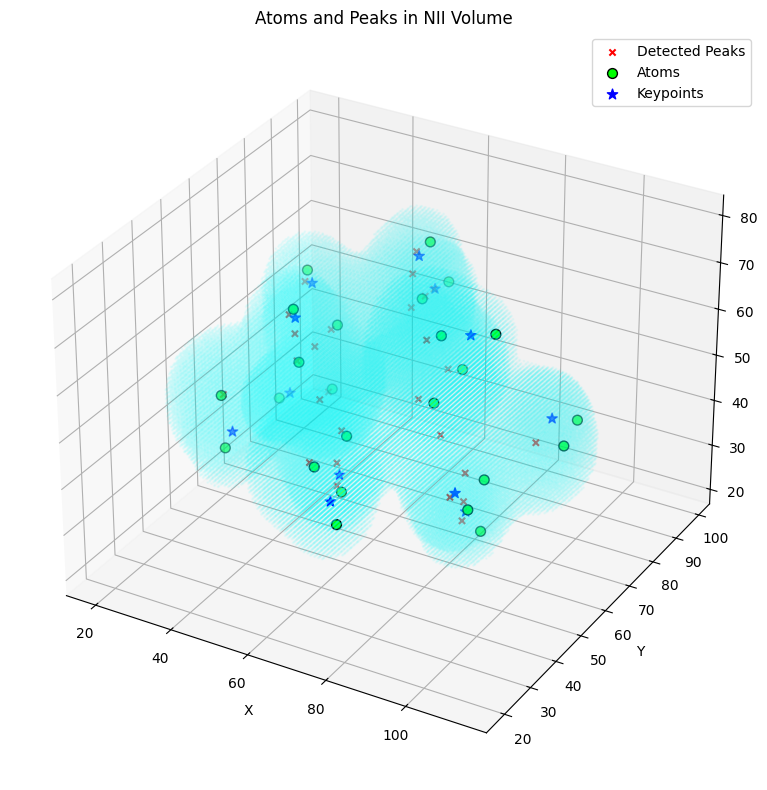

In [55]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import peak_local_max
from rdkit import Chem
from rdkit.Chem import AllChem

# File paths
nii_file = 'data/nii/D-Fructose.nii'
sdf_file = 'data/sdf/D-Fructose.sdf'

# Load NIfTI density
img = nib.load(nii_file)
data = img.get_fdata()
shape = np.array(data.shape)

# Detect peaks in voxel space
coordinates_vox = peak_local_max(data, min_distance=3, threshold_abs=0.5)
print(f"Number of peaks detected: {len(coordinates_vox)}")


# Load atoms from SDF (including H)
mol = Chem.MolFromMolFile(sdf_file, removeHs=False)
conf = mol.GetConformer()
atom_coords = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])

# --- Coordinate system alignment ---

# Step 1: Center atom coordinates around origin
atom_coords_centered = atom_coords - atom_coords.mean(axis=0)

# Step 2: Scale atom coordinates to match .nii volume size
max_range = np.max(np.linalg.norm(atom_coords_centered, axis=1))  # max radius from center
scale_factor = min(shape) / (2 * max_range * 1.2)  # slight margin
atom_coords_scaled = atom_coords_centered * scale_factor

# Step 3: Shift to center of volume
atom_coords_vox = atom_coords_scaled + shape / 2

# --- Plotting ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Cyan cloud for density (thresholded)
threshold = 0.1
x, y, z = np.where(data > threshold)
ax.scatter(x, y, z, c='cyan', alpha=0.05, s=1)

# Red crosses for detected peaks
ax.scatter(coordinates_vox[:, 0], coordinates_vox[:, 1], coordinates_vox[:, 2],
           c='red', marker='x', label='Detected Peaks')

# Green atoms (scaled and centered)
ax.scatter(atom_coords_vox[:, 0], atom_coords_vox[:, 1], atom_coords_vox[:, 2],
           c='lime', edgecolors='black', s=50, label='Atoms')

ax.scatter(
    coordinates['X'], coordinates['Y'], coordinates['Z'],
    color='blue', marker='*', s=60, label='Keypoints'
)

ax.set_title("Atoms and Peaks in NII Volume")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.savefig('/home/aryanshukla/Desktop/Experiments/Results/PeaksAtomsAlignment/PeaksAtoms.png', dpi=300)
plt.show()


In [56]:
import pandas as pd

# 1. Density cloud points
df_density = pd.DataFrame({
    "x": x,
    "y": y,
    "z": z
})
df_density.to_csv("density_points.csv", index=False)
print(f"Saved density cloud points: {len(df_density)} rows")

# 2. Detected peaks
df_peaks = pd.DataFrame(coordinates_vox, columns=["x", "y", "z"])
df_peaks.to_csv("detected_peaks.csv", index=False)
print(f"Saved detected peaks: {len(df_peaks)} rows")

# 3. Atom coordinates
df_atoms = pd.DataFrame(atom_coords_vox, columns=["x", "y", "z"])
df_atoms.to_csv("atom_coords_vox.csv", index=False)
print(f"Saved atom coordinates: {len(df_atoms)} rows")

# 4. Optional: Keypoints (if variable exists)
try:
    df_keys = pd.DataFrame({
        "x": coordinates["X"],
        "y": coordinates["Y"],
        "z": coordinates["Z"]
    })
    df_keys.to_csv("keypoints.csv", index=False)
    print(f"Saved keypoints: {len(df_keys)} rows")
except Exception as e:
    print("Keypoints not found or skipped:", e)


Saved density cloud points: 138827 rows
Saved detected peaks: 27 rows
Saved atom coordinates: 24 rows
Saved keypoints: 12 rows


In [57]:
%pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


X: [[0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]]
Y: [[0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6]
 [7 7 7 7 7 7 7 7]]
Z: [[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  1.62980699e-34 -2.30489515e-34  1.62980699e-34
  -1.41134123e-49 -1.62980699e-34  2.30489515e-34 -1.62980699e-34]
 [ 0.00000000e+00 -2.30489515e-34  3.25961398e-34 -2.30489515e-34
   1.99593792e-49  2.30489515e-34 -3.25961398e-34  2.30489515e-34]
 [-0.00000000e+00  1.62980699e-34 -2.30489515e-34  1.62980699e-34
  -1.41134123e-49 -1.62980699e-34  2.30489515e-34 -1.62980699e-34]
 [ 0.00000000e+00 -1.41134123e-49  1.99593792e-49 -1.41134123e-49
   1.22215949e-64  1.41134123e-49 -1.99593792e-49  1.41134123e-49]
 [ 0.00000000e+00 -1

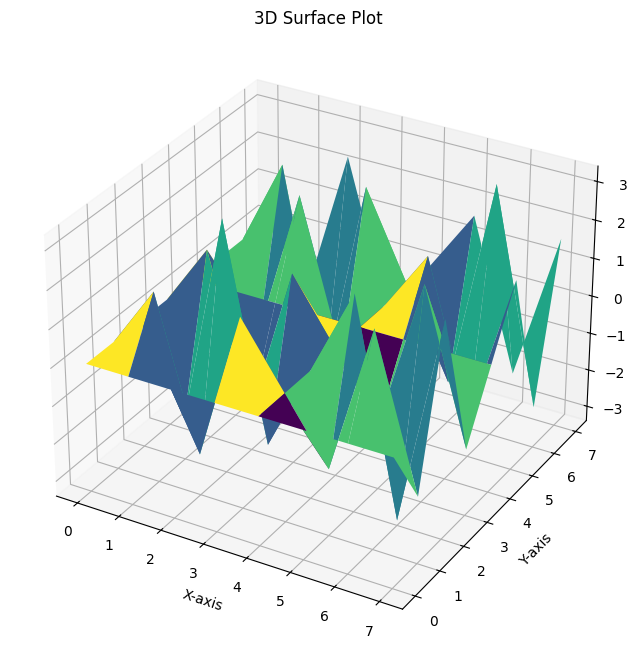

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100
n = 10
m = 10

length = 8
width = 8
initialScale = 1.0
scales = []
divPerOctave = 2

# Compute scales; note that we use a different variable (j) in the inner loop for clarity
for i in range(N):
    scalesPerOctave = [initialScale * (2 ** (j / divPerOctave)) for j in range(N)]
    scales.append(scalesPerOctave)

alpha = 0.5

def scaleSpace(sigma):
    # Create coordinate arrays
    x = np.arange(length)
    y = np.arange(width)
    # Create a 2D grid for the surface
    X, Y = np.meshgrid(x, y)
    # Compute Z on the grid
    # Note: Parentheses clarify the denominator for the exponential term.
    Z = (np.sin(n * np.pi * X / length) *
         np.sin(m * np.pi * Y / width) *
         np.exp(- (m * n * np.pi**2 * alpha * sigma) / (length * width)))
    return X, Y, Z

# Generate the data with a chosen sigma (e.g., sigma = 10)
X, Y, Z = scaleSpace(10)
print("X:", X)
print("Y:", Y)
print("Z:", Z)
# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add titles and labels
ax.set_title("3D Surface Plot")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()


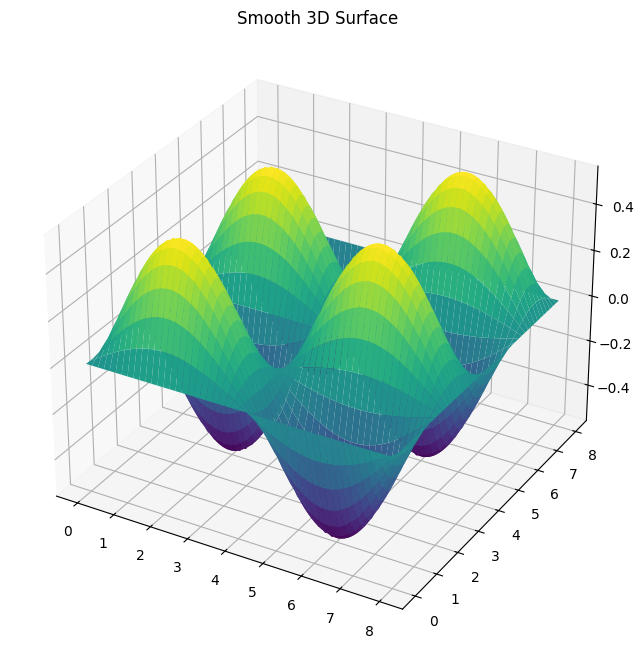

In [ ]:
length = 8
width = 8
n, m = 2, 4
alpha = 0.5
sigma = 1

# Dense grid instead of integer-only
x = np.linspace(0, length, 500)
y = np.linspace(0, width, 500)
X, Y = np.meshgrid(x, y)

Z = (np.sin(n * np.pi * X / length) *
     np.sin(m * np.pi * Y / width) *
     np.exp(- (m * n * np.pi**2 * alpha * sigma) / (length * width)))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title("Smooth 3D Surface")
plt.show()

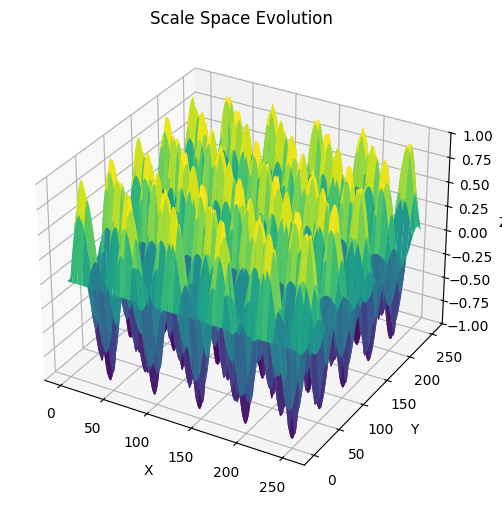

In [9]:
from matplotlib.animation import FuncAnimation

# Parameters
n, m = 10, 10
length, width = 256, 256
alpha = 0.5

# Meshgrid
x = np.arange(length)
y = np.arange(width)
X, Y = np.meshgrid(x, y)

# Scale space function
def scaleSpace(sigma):
    Z = (np.sin(n * np.pi * X / length) *
         np.sin(m * np.pi * Y / width) *
         np.exp(- (m * n * np.pi**2 * alpha * sigma) / (length * width)))
    return Z

# Create figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Initial surface
Z = scaleSpace(1.0)
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_zlim(-1, 1)  # Fixed z-limits
ax.set_title("Scale Space Evolution")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Update function for animation
def update(frame):
    sigma = frame
    ax.clear()
    Z = scaleSpace(sigma)
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title(f"Sigma = {sigma:.2f}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_zlim(-1, 1)

# Animation setup
sigmas = np.linspace(1, 100, 60)  # 60 frames
ani = FuncAnimation(fig, update, frames=sigmas, interval=1)

# To display in notebook (if using Jupyter)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# To save as video or gif:
# ani.save("scale_space.mp4", writer='ffmpeg')  # Needs ffmpeg installed
# ani.save("scale_space.gif", writer='pillow')  # For gif output

plt.show()
